In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import numpy as np
from scipy.stats import multivariate_normal

np.random.seed(0)

### Create a dataset

In [ ]:
K=3 # number of sources
d=2 # dimension of the data
    
def create_dataset():
    # Create dataset
    
    X=[]
    mu1=[2,2]
    Sigma1=np.array([[3,-2],[-2,3]])
    Gauss1= multivariate_normal(mean=mu1,cov=Sigma1)
    samples1=Gauss1.rvs(200) # Draw random samples from the multivariate normal distribution.

    mu2=[-8,-4]
    Sigma2=np.array([[4,2],[2,4]])
    Gauss2= multivariate_normal(mean=mu2,cov=Sigma2)
    samples2=Gauss2.rvs(400)

    mu3=[-8,7]
    Sigma3=np.array([[1,0],[0,1]])
    Gauss3= multivariate_normal(mean=mu3,cov=Sigma3)
    samples3=Gauss3.rvs(600)

    X=np.vstack((samples1,samples2,samples3))
    
    np.random.shuffle(X)
    return X


In [ ]:
X=create_dataset()
n_samples = len(X)
print(X.shape)

(1200, 2)


Text(0.5, 1.0, 'Dataset')

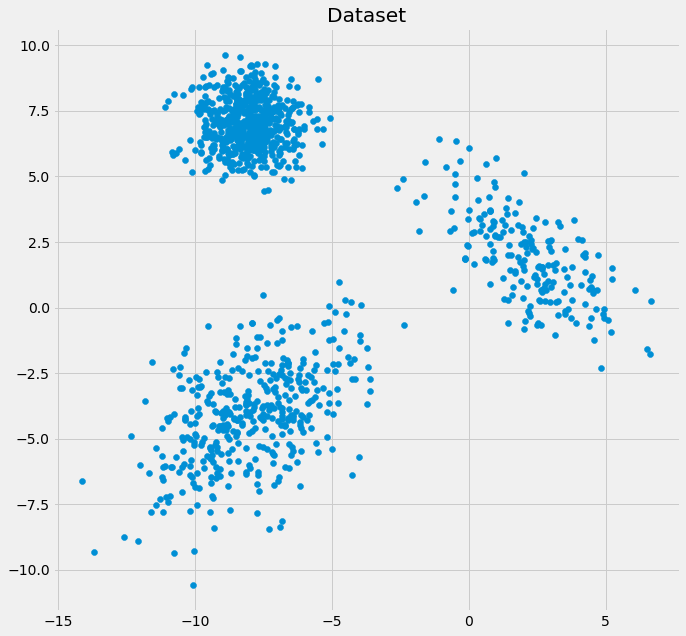

In [ ]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.scatter(X[:,0],X[:,1])
ax0.set_title('Dataset')

### Initalize Parameters

In [ ]:
 
def init_params(K,d):
    """ Set the initial mu, covariance and pi values"""

    # This is a Kxd matrix since we assume K Gaussians where each has d dimensions
    mu=np.array([[1.0,0.0],[-5.0,2.0],[-2.0,-2.0]])
    #mu = np.random.randint(-4,4,size=(K,d)) 

    print(mu)

    
    # We need a Kxdxd covariance matrix for each Gauss distribution since we have d features 
    #--> We create symmetric covariance matrices with ones on the digonal
    
    cov = np.zeros((K,d,d))
    print(cov.shape)

    for dim in range(len(cov)):
        np.fill_diagonal(cov[dim],2.0)

    print(cov)

    # Set pi to uniform distribution
    pi = np.ones(K)/K 
    print(pi)

    return mu, cov, pi



In [ ]:
mu, cov, pi = init_params(K,d)

[[ 1.  0.]
 [-5.  2.]
 [-2. -2.]]
(3, 2, 2)
[[[2. 0.]
  [0. 2.]]

 [[2. 0.]
  [0. 2.]]

 [[2. 0.]
  [0. 2.]]]
[0.33333333 0.33333333 0.33333333]


In [ ]:
def plot_results(X, **kwargs):
    """Plot the dataset"""    
    
    fig = plt.figure(figsize=(10,10))
    ax0 = fig.add_subplot(111)
    ax0.scatter(X[:,0],X[:,1])
    
    try:
      title = kwargs['title']
    except:
      title='results'
    ax0.set_title(title)
    
    try:
        mu = kwargs['mu']
        for m in mu:
            ax0.scatter(m[0],m[1],c='red',zorder=10,s=100)
    except:
        pass
    
    try:
        cov = kwargs ['cov']
        x,y = np.meshgrid(np.sort(X[:,0]),np.sort(X[:,1]))
        XY = np.array([x.flatten(),y.flatten()]).T
        reg_cov = 1e-6*np.identity(len(X[0,:]))
        
        for c,m in zip(cov,mu):
            c += reg_cov
            # let us set up the mean and covariance of a multi-dim gaussian
            multi_normal = multivariate_normal(mean=m,cov=c)
            ax0.contour(np.sort(X[:,0]),np.sort(X[:,1]),multi_normal.pdf(XY).reshape(len(X),len(X)),colors='black',alpha=0.3)
    
    except:
        pass
    
    plt.show()
    fig.savefig(title+'.png')

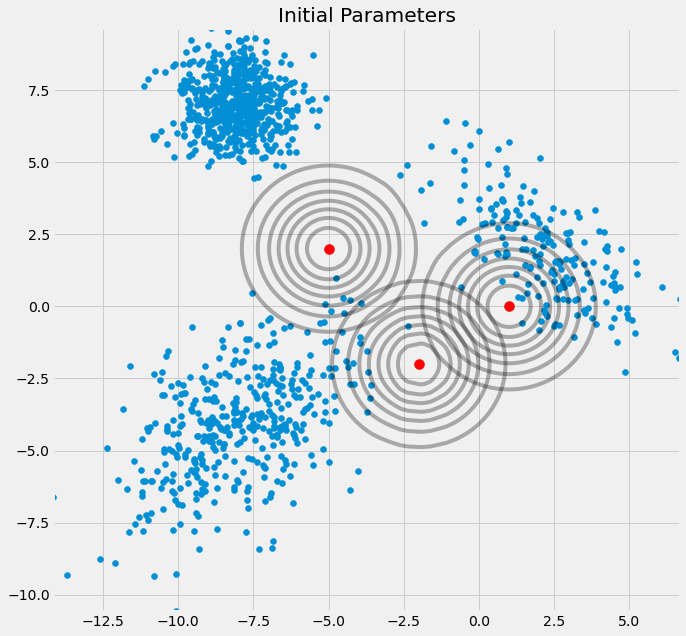

In [ ]:
plot_results(X, mu=mu,cov=cov, title='Initial Parameters')

### E Step starts here

In [ ]:
reg_cov = 1e-6*np.identity(d)
log_likelihoods = [] # In this list we store the log likehoods per iteration and plot them in the end to check if
                     # if we have converged

$$R_{i,j}^{t-1}=\frac{\frac{1}{\sqrt{|2\pi\Sigma_i^{t-1}|}}\exp\left\{-\frac{1}{2}(x_j-\mu_i^{t-1})^T(\Sigma_i^{t-1})^{-1}(x_j-\mu_i^{t-1})\right\}\pi_i^{t-1}}
{\sum_{l=1}^{K} \frac{1}{\sqrt{|2\pi\Sigma_l^{t-1}|}} \exp\left\{-\frac{1}{2}(x_j-\mu_l^{t-1})^T(\Sigma_l^{t-1})^{-1}(x_j-\mu_l^{t-1})\right\}\pi_l^{t-1}}$$

In [ ]:
# Calculate for each datapoint x_j the probability r_ij that datapoint x_j belongs to cluster i

r_ij = np.zeros([K,n_samples])
print(r_ij.shape)

for j in range(n_samples):
    for i in range(K):
        mn = multivariate_normal(mean=mu[i,:],cov=cov[i,:,:]+reg_cov)
        r_ij[i,j]=pi[i]*mn.pdf(X[j,:])
    r_ij[:,j]=r_ij[:,j]/np.sum(r_ij[:,j])

(3, 1200)


In [ ]:
r_ij[:,300:308]

array([[7.28335923e-08, 1.13049262e-10, 1.43789704e-07, 9.98609506e-01,
        1.09992442e-10, 1.77478260e-06, 9.94294415e-01, 3.40493217e-11],
       [9.99999868e-01, 9.99999993e-01, 6.54640892e-03, 3.94860316e-04,
        9.99999994e-01, 1.07776214e-01, 5.27623127e-03, 9.99999999e-01],
       [5.87058219e-08, 7.09390626e-09, 9.93453447e-01, 9.95634094e-04,
        5.69888417e-09, 8.92222011e-01, 4.29353421e-04, 7.02221765e-10]])

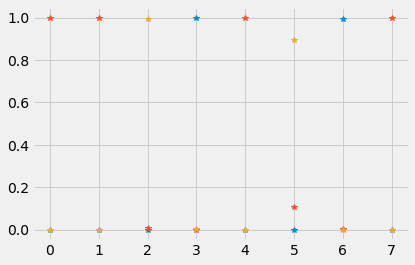

In [ ]:
# just for debugging
plt.plot(r_ij[:,300:308].T,'*')

### M-Step starts here

$$\mu_i^t=\sum_{j=1}^n w_{ij} x_j
\textrm{, where }  w_{ij} =\frac {P( y_j=i|x_j,\theta^{t-1})}{\sum_{l=1}^n P( y_l=i|x_l,\theta^{t-1})} = \frac{R_{ij}}{\sum_{l=1}^n R_{il}}
$$

$$\Sigma_i^t=\sum_{j=1}^n w_{ij}(x_j-\mu_i^t)^T(x_j-\mu_i^t)$$

$$\pi_i^t=\frac{1}{n}\sum_{j=1}^n R_{ij}$$

In [ ]:
"""M Step"""
# Calculate the new mean vector and new covariance matrices
mu = []
cov = []
pi = []
log_likelihood = []

In [ ]:
w_ij=np.zeros([K,n_samples])
for i in range(K):
  for j in range(n_samples):
    w_ij[i,j] = r_ij[i,j]/np.sum(r_ij[i,:])

In [ ]:
for i in range(K):
  # Updating the mean vectors mu_i:
  mu_i = np.zeros([1,d])
  for j in range(n_samples):
    mu_i=mu_i+w_ij[i,j]*X[j,:]
  mu.append(mu_i)

In [ ]:
for i in range(K):
  Sigma_i = np.zeros([d,d])
  for j in range(n_samples):
    Sigma_i = Sigma_i + w_ij[i,j]*np.dot((X[j,:]- mu[i]).T,  X[j,:]- mu[i])
  cov.append(Sigma_i)
print(cov)

[array([[ 2.4984899 , -1.53385487],
       [-1.53385487,  2.46660871]]), array([[ 2.08619765,  1.03314813],
       [ 1.03314813, 15.97780823]]), array([[4.04102616, 2.45711407],
       [2.45711407, 3.18532661]])]


In [ ]:
for i in range(K):
  # Calculate pi_new
  pi.append(1/n_samples*np.sum(r_ij[i,:])) 
print(pi)

[0.15753340516660463, 0.6245454813958753, 0.21792111343752008]


In [ ]:
mu=np.squeeze(np.array(mu))
print(mu)

"""Log likelihood"""
log_likelihoods.append(np.log(np.sum([k*multivariate_normal(mu[i],cov[j]).pdf(X) for k,i,j in zip(pi,range(len(mu)),range(len(cov)))])))

print(log_likelihoods)

[[ 2.31677332  1.7374983 ]
 [-8.05863195  5.15331018]
 [-7.65336193 -4.71705356]]
[2.419982463935921]


In [ ]:
cov=np.array(cov)
print(cov)

[[[ 2.4984899  -1.53385487]
  [-1.53385487  2.46660871]]

 [[ 2.08619765  1.03314813]
  [ 1.03314813 15.97780823]]

 [[ 4.04102616  2.45711407]
  [ 2.45711407  3.18532661]]]


In [ ]:
print(pi)

[0.15753340516660463, 0.6245454813958753, 0.21792111343752008]


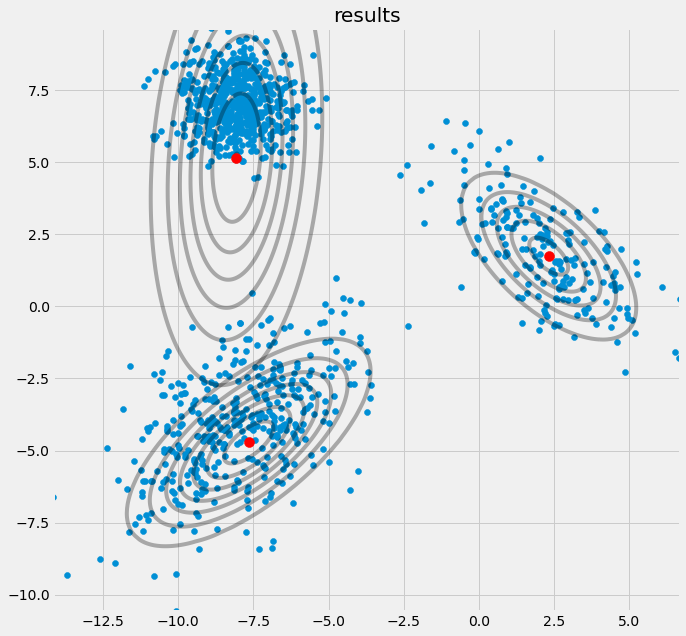

In [ ]:
plot_results(X, mu=mu,cov=cov)

In [ ]:
print("Now go back to the E Step!")

Now go back to the E Step!


### Putting everything together

In [ ]:
class GMM:
    def __init__(self,X,number_of_sources,iterations):
        self.iterations = iterations
        self.number_of_sources = number_of_sources
        self.dim = 2
        self.X = X
        self.mu = None
        self.pi = None
        self.cov = None
        self.XY = None
        
    
    """Define a function which runs for iterations, iterations"""
    def run(self):
        self.reg_cov = 1e-6*np.identity(len(X[0,:]))
           
        n_samples= len(self.X)
        K= 3

        """ 1. Set the initial mu, covariance and pi values"""
        np.random.seed(0)
        self.mu, self.cov, self.pi = init_params(self.number_of_sources,self.dim)
        
        log_likelihoods = [] # In this list we store the log likehoods per iteration and plot them in the end to check if
                             # if we have converged
         
        plot_results(X,mu=self.mu,cov=self.cov)
        
        for iter in range(self.iterations):  
            print('iter:', iter)
            """E Step"""

            mu = self.mu
            cov = self.cov
            pi = self.pi

            r_ij = np.zeros([K,n_samples])

            for j in range(n_samples):
                for i in range(K):
                     mn = multivariate_normal(mean=mu[i,:],cov=cov[i,:,:]+reg_cov)
                     r_ij[i,j]=pi[i]*mn.pdf(X[j,:])
                r_ij[:,j]=r_ij[:,j]/np.sum(r_ij[:,j])

            """M Step"""
            # Calculate the new mean vector and new covariance matrices, based on the probable membership of the single x_i to classes c --> r_ic
            self.mu = []
            self.cov = []
            self.pi = []
            log_likelihood = []

            w_ij=np.zeros([K,n_samples])
            for i in range(K):
              for j in range(n_samples):
                w_ij[i,j] = r_ij[i,j]/np.sum(r_ij[i,:])

            # Calculate mu_new
            for i in range(K):
              # Updating the mean vectors mu_i:
              mu_i = np.zeros([1,d])
              for j in range(n_samples):
                mu_i=mu_i+w_ij[i,j]*X[j,:]
              self.mu.append(mu_i)

            # Calculate Sigma_new
            for i in range(K):
              Sigma_i = np.zeros([d,d])
              for j in range(n_samples):
                Sigma_i = Sigma_i + w_ij[i,j]*np.dot((X[j,:]- self.mu[i]).T,  X[j,:]- self.mu[i])
              self.cov.append(Sigma_i)
            
            # Calculate pi_new
            for i in range(K):
              self.pi.append(1/n_samples*np.sum(r_ij[i,:])) 
            
            self.mu = np.squeeze(np.array(self.mu))

            print('mu:', np.array(self.mu))
            print('cov:', np.array(self.cov))
            print('pi:', self.pi)
            
            self.mu = np.squeeze(np.array(self.mu))
            self.cov = np.array(self.cov)
            self.pi =np.array(self.pi)


            """Log likelihood"""
            log_likelihoods.append(np.log(np.sum([k*multivariate_normal(self.mu[i],self.cov[j]).pdf(X) for k,i,j in zip(self.pi,range(len(self.mu)),range(len(self.cov)))])))
            
            
            plot_results(X,mu=self.mu,cov=self.cov, title=f'results_{iter+1}')
            
        fig2 = plt.figure(figsize=(10,10))
        ax1 = fig2.add_subplot(111) 
        ax1.set_title('Log-Likelihood')
        ax1.plot(range(0,self.iterations,1),log_likelihoods)
        #plt.show()
           
    
    


[[ 1.  0.]
 [-5.  2.]
 [-2. -2.]]
(3, 2, 2)
[[[2. 0.]
  [0. 2.]]

 [[2. 0.]
  [0. 2.]]

 [[2. 0.]
  [0. 2.]]]
[0.33333333 0.33333333 0.33333333]


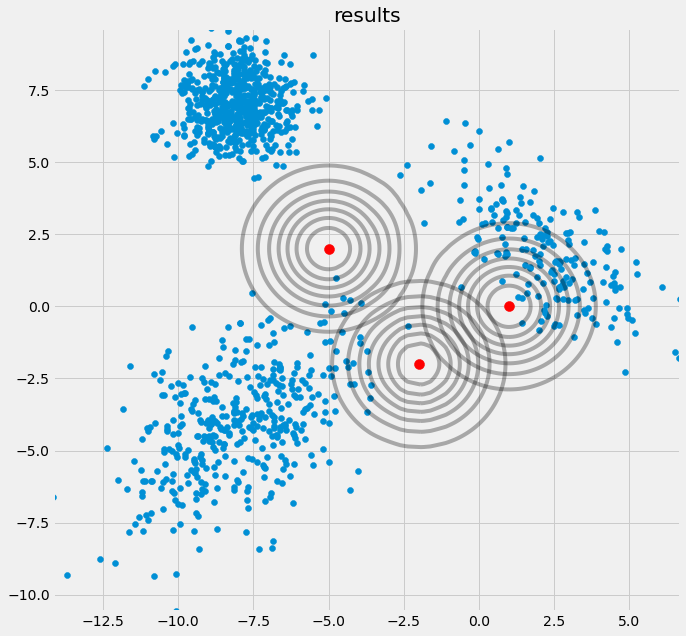

iter: 0
mu: [[ 2.31677332  1.7374983 ]
 [-8.05863195  5.15331018]
 [-7.65336193 -4.71705356]]
cov: [[[ 2.4984899  -1.53385487]
  [-1.53385487  2.46660871]]

 [[ 2.08619765  1.03314813]
  [ 1.03314813 15.97780823]]

 [[ 4.04102616  2.45711407]
  [ 2.45711407  3.18532661]]]
pi: [0.15753340516660463, 0.6245454813958753, 0.21792111343752008]


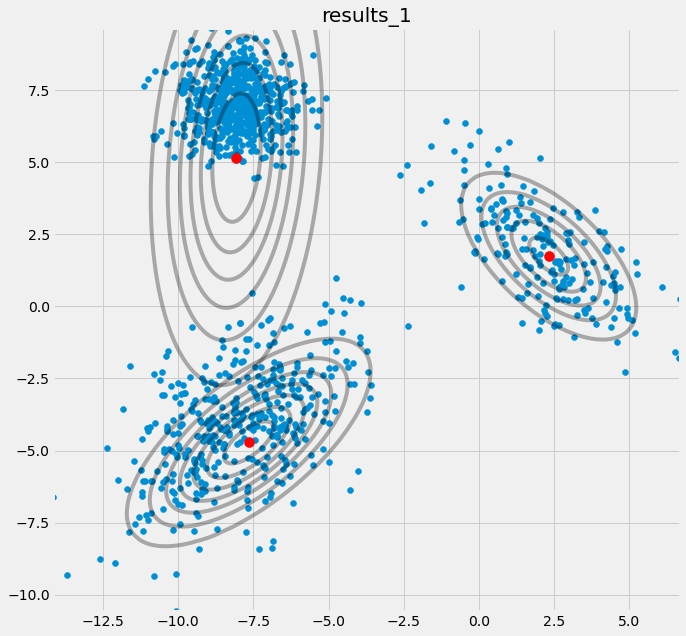

iter: 1
mu: [[ 2.12943453  1.8953263 ]
 [-8.10406319  5.85958474]
 [-7.85846229 -4.48655409]]
cov: [[[ 3.03693168 -1.99544334]
  [-1.99544334  2.85997643]]

 [[ 1.21068326  0.48037644]
  [ 0.48037644 10.89575048]]

 [[ 4.11804646  2.25454929]
  [ 2.25454929  3.14859403]]]
pi: [0.1664420311924693, 0.5691578374068503, 0.26440013140068036]


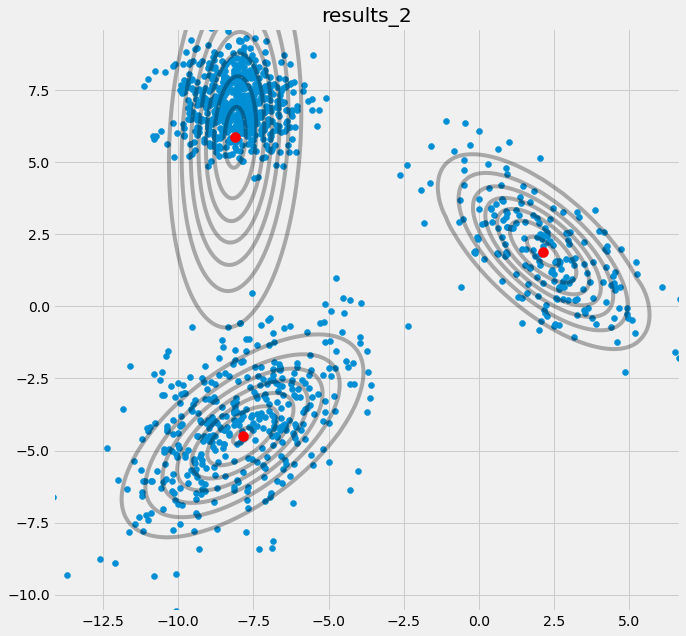

iter: 2
mu: [[ 2.12544009  1.89735036]
 [-8.0775827   6.6105763 ]
 [-7.94157689 -4.27352004]]
cov: [[[ 3.05280483 -2.00383279]
  [-2.00383279  2.86410786]]

 [[ 1.02519151  0.13211352]
  [ 0.13211352  4.37015544]]

 [[ 4.02291973  2.03382801]
  [ 2.03382801  3.36098662]]]
pi: [0.16659183160682836, 0.5245955481564055, 0.3088126202367662]


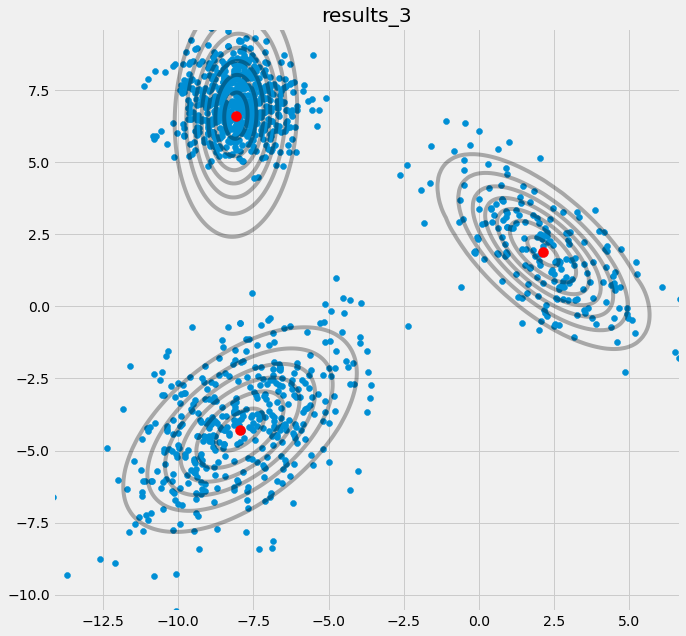

iter: 3
mu: [[ 2.12530826  1.8972529 ]
 [-8.06148483  7.00342546]
 [-7.97565517 -4.09981015]]
cov: [[[ 3.0530317  -2.00355698]
  [-2.00355698  2.8641716 ]]

 [[ 0.97934921 -0.03457779]
  [-0.03457779  1.05108135]]

 [[ 3.88575917  1.85893313]
  [ 1.85893313  3.61711859]]]
pi: [0.16660102241063432, 0.5011997006315937, 0.33219927695777207]


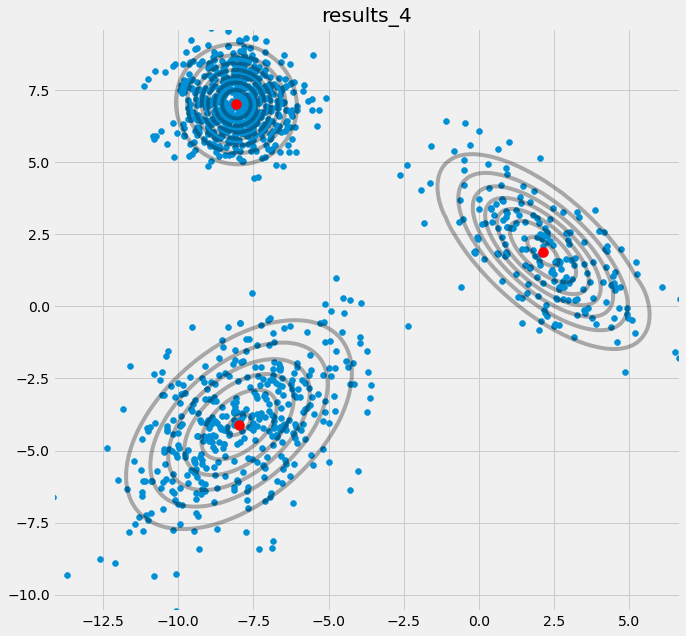

iter: 4
mu: [[ 2.12535938  1.89703008]
 [-8.06190871  7.0207953 ]
 [-7.97550195 -4.08571432]]
cov: [[[ 3.05204093 -2.00244327]
  [-2.00244327  2.86369379]]

 [[ 0.98003195 -0.0321935 ]
  [-0.0321935   0.92722703]]

 [[ 3.87265878  1.85396546]
  [ 1.85396546  3.66100926]]]
pi: [0.1666058674570553, 0.49999497912652935, 0.3333991534164154]


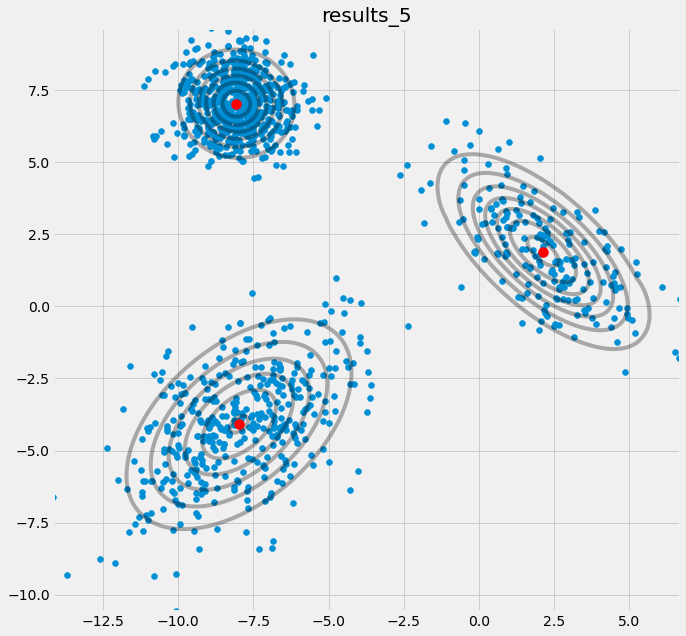

iter: 5
mu: [[ 2.12538383  1.89700811]
 [-8.06190762  7.02079543]
 [-7.97549793 -4.08569834]]
cov: [[[ 3.05190666 -2.00234844]
  [-2.00234844  2.86366051]]

 [[ 0.98003492 -0.03219345]
  [-0.03219345  0.92722599]]

 [[ 3.872655    1.85403884]
  [ 1.85403884  3.66115797]]]
pi: [0.16660527848816212, 0.49999514035776943, 0.3333995811540684]


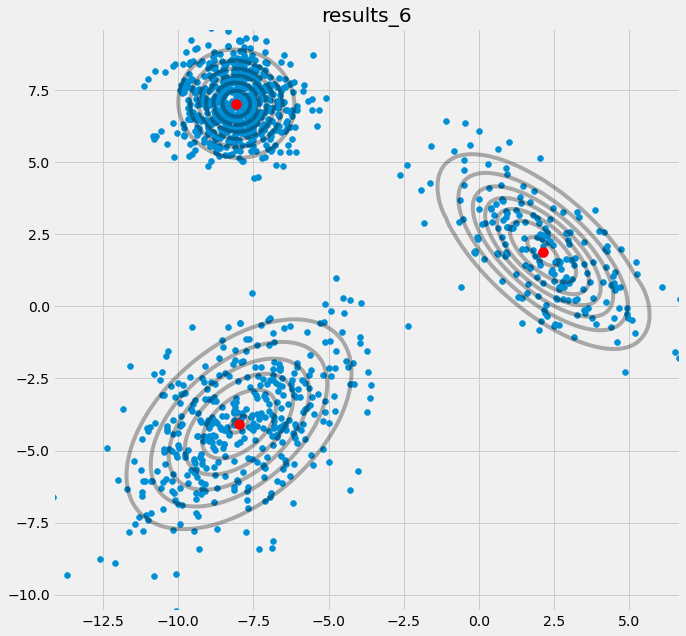

iter: 6
mu: [[ 2.12538414  1.89700799]
 [-8.0619076   7.02079543]
 [-7.97549774 -4.08569813]]
cov: [[[ 3.05190534 -2.00234783]
  [-2.00234783  2.8636602 ]]

 [[ 0.98003495 -0.03219344]
  [-0.03219344  0.92722598]]

 [[ 3.87265614  1.85404007]
  [ 1.85404007  3.66115929]]]
pi: [0.16660526651858434, 0.4999951425347592, 0.33339959094665655]


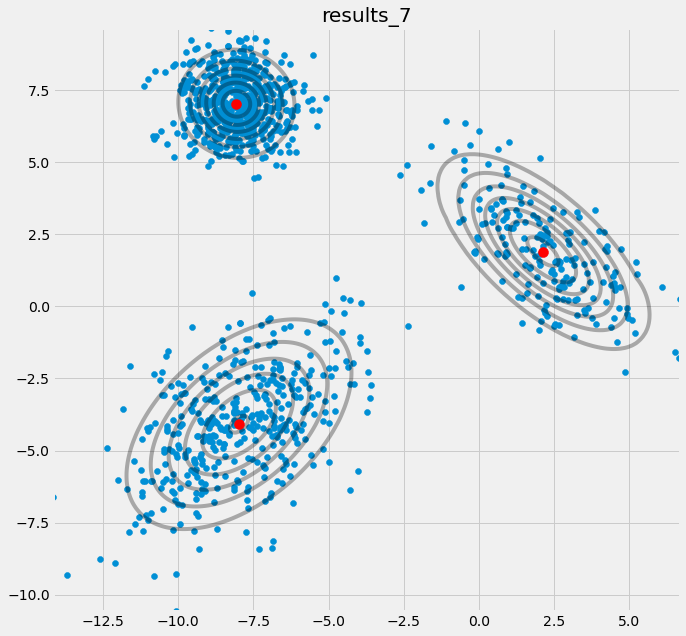

iter: 7
mu: [[ 2.12538415  1.89700799]
 [-8.0619076   7.02079543]
 [-7.97549774 -4.08569813]]
cov: [[[ 3.05190532 -2.00234783]
  [-2.00234783  2.8636602 ]]

 [[ 0.98003495 -0.03219344]
  [-0.03219344  0.92722598]]

 [[ 3.87265618  1.85404011]
  [ 1.85404011  3.66115932]]]
pi: [0.16660526619800067, 0.4999951425558677, 0.33339959124613167]


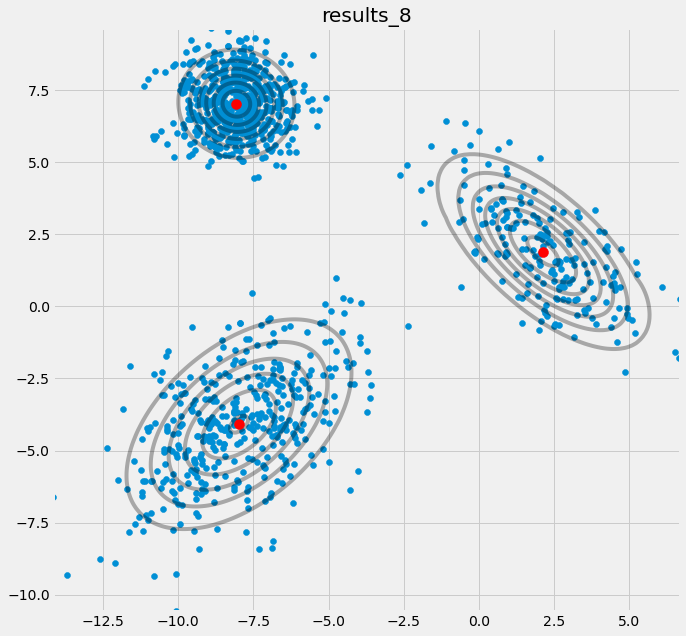

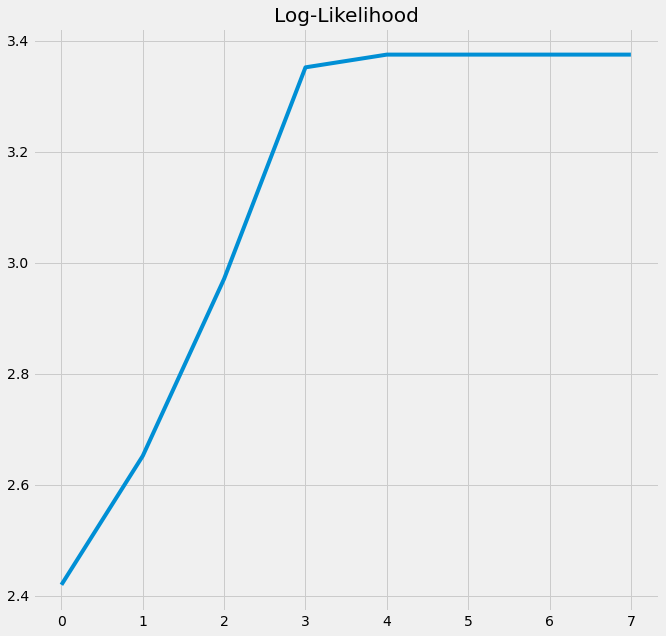

In [ ]:
GMM = GMM(X,3,8)     
GMM.run()
#GMM.predict([[0.5,0.5]])